# Propensity Scores

In [23]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import KFold
from sklearn import metrics

## Tests

In [24]:
data = pkl.load(open('../data/data.pkl', 'rb'))
data.head(2)

,confidence,index,time,token_path,term_match,word_net,T,Y
0,28.4,11,23.0,0.614881,1.000000,1.000000,0,46
1,45.8,13,21.0,0.405652,0.672727,0.536469,0,4


In [14]:
models = []
rocs = []
for i, (train_index, test_index) in enumerate(KFold(5).split(data)):
    train = data.iloc[train_index, :]
    test = data.iloc[test_index, :]
    x_train = train[train.columns[~train.columns.isin(['T','Y'])]]
    x_test = test[test.columns[~test.columns.isin(['T','Y'])]]
    t_train = train['T'].values
    t_test = test['T'].values
    
    # Logistic regression
    log_reg = LogisticRegression(max_iter=10000).fit(x_train, t_train)
    probs_train = log_reg.predict_proba(x_train)[:,1]
    probs_test = log_reg.predict_proba(x_test)[:, 1]
    test_fpr, test_tpr, _ = metrics.roc_curve(test['T'],  probs_test)
    test_auc = metrics.roc_auc_score(test['T'],  probs_test)
    train_fpr, train_tpr, _ = metrics.roc_curve(train['T'],  probs_train)
    train_auc = metrics.roc_auc_score(train['T'],  probs_train)
    models.append({'name': 'LR', 'epoch':i, 'train auc':train_auc, 'test auc':test_auc})
    rocs.append({'name': 'LR', 'epoch':i, 'test_fpr':test_fpr, 'test_tpr':test_tpr, 'train_fpr':train_fpr, 'train_tpr':train_tpr})

In [15]:
models = pd.DataFrame(models)
models[['name', 'train auc', 'test auc']].groupby('name').mean()

,train auc,test auc
name,,
LR,0.757189,0.750255


In [16]:
rocs = pd.DataFrame(rocs)

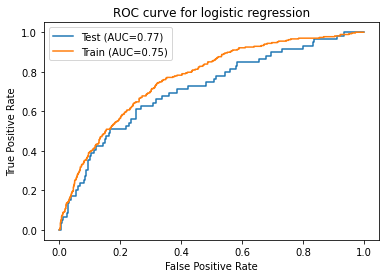

In [26]:
fig, ax = plt.subplots()
epoch = 0
for i, name in enumerate(['LR']):
    alg_epoch = rocs[(rocs['epoch']==epoch)&(rocs['name']==name)]
    test_fpr, test_tpr = alg_epoch['test_fpr'].item(), alg_epoch['test_tpr'].item()
    train_fpr, train_tpr = alg_epoch['train_fpr'].item(), alg_epoch['train_tpr'].item()
    
    ax.plot(test_fpr, test_tpr, label=f'Test (AUC={round(test_auc,2)})')
    ax.plot(train_fpr, train_tpr, label=f'Train (AUC={round(train_auc,2)})')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.legend()
    ax.set_title(f"ROC curve for logistic regression")
plt.show()

## Final calculation

In [7]:
data = pkl.load(open('../data/data.pkl', 'rb'))
data.head(2)

,confidence,index,time,token_path,term_match,word_net,T,Y
0,28.4,11,23.0,0.614881,1.000000,1.000000,0,46
1,45.8,13,21.0,0.405652,0.672727,0.536469,0,4


In [8]:
def calc_props(df):
    x, t = df[df.columns[~df.columns.isin(['T','Y'])]], df['T'].values
    log_reg = LogisticRegression(max_iter=10000).fit(x, t)
    df['propensity'] = log_reg.predict_proba(x)[:,1]
    return df

In [9]:
data = calc_props(data)

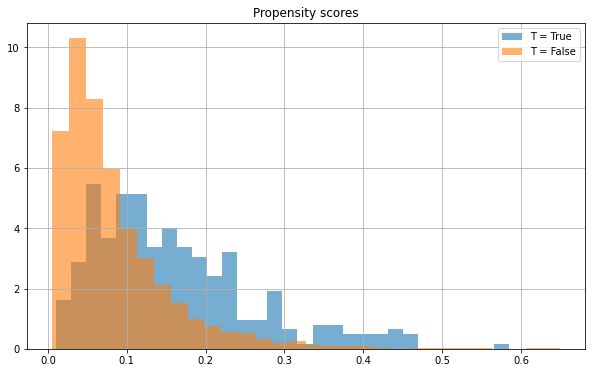

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
data[data['T']==1].propensity.hist(bins=30, ax=ax, alpha=0.6, density=True, label='T = True')
data[data['T']==0].propensity.hist(bins=30, ax=ax, alpha=0.6, density=True, label='T = False')
plt.title("Propensity scores")
plt.legend()
plt.show()

In [11]:
save = True
if save:
    pkl.dump(data, open("../data/data_p.pkl", "wb"))